<h1><center><b>Risk Analysis using Neural Networks</b></center></h1>

This notebook performs a risk analysis on a stock portfolio by computing Value at Risk (VaR) and Conditional Value at Risk (CVaR) using historical returns, parametric methods, Monte Carlo simulation, and neural network-based predictions. It compares these approaches to evaluate potential losses under normal and extreme market conditions.


## Install dependencies


In [1]:
!pip3 install yfinance pandas numpy matplotlib scipy scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 34.1 MB/s eta 0:00:00 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [3]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf

from sklearn.preprocessing import StandardScaler

## Downloading Stock Data

We use `yfinance` to fetch historical stock data for a selected portfolio.

- For this project, will be using Apple, Meta, Amazon and Google stock prices for the last 5 years


In [ ]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2025, 1, 1)

df = yf.download(["AAPL", "META", "AMZN", "GOOG"], start=start_date, end=end_date)
df = df["Close"]
df = df.dropna()
returns = df.pct_change().dropna()
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,META
Date,,,,
2020-01-02,72.716072,94.900497,68.046204,208.795944
2020-01-03,72.009102,93.748497,67.712288,207.691147
2020-01-06,72.582901,95.143997,69.381874,211.602722
2020-01-07,72.241554,95.343002,69.338577,212.060562
2020-01-08,73.403648,94.598503,69.884995,214.210419


## Prepare data for training


In [14]:
X = returns.shift(1).dropna().values
y = returns.values[1:]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

## Define Neural Network

- **Input Layer**: Takes `input_dim` features.
- **Hidden Layers**: Two layers with 64 and 32 neurons, ReLU activation, BatchNorm, and Dropout (30%) for regularization.
- **Output Layer**: Linear layer projecting to `output_dim`.
- **Loss Function**: Mean Squared Error (MSE Loss).
- **Optimizer**: Adam with learning rate `0.001`.


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(32, output_dim),
        )

        self._initialize_weights()

    def forward(self, x):
        return self.net(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

## Initialize and train the model


In [ ]:
model = NeuralNetwork(input_dim=X.shape[1], output_dim=y.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

Epoch [10/100], Loss: 0.443529
Epoch [20/100], Loss: 0.285511
Epoch [30/100], Loss: 0.209169
Epoch [40/100], Loss: 0.168554
Epoch [50/100], Loss: 0.146553
Epoch [60/100], Loss: 0.123759
Epoch [70/100], Loss: 0.110987
Epoch [80/100], Loss: 0.100484
Epoch [90/100], Loss: 0.095057
Epoch [100/100], Loss: 0.081789


## Predict returns


In [8]:
with torch.no_grad():
    predicted_returns = model(X_tensor).numpy()

## Risk Estimation using VaR and CVAR

Use the predicted returns to compute VaR and CVaR and compare them with actuals.


In [ ]:
initial_investment = 100000
investment_per_stock = initial_investment / len(df.columns)

predicted_dollar_returns = predicted_returns * investment_per_stock
predicted_dollar_returns_aligned = predicted_dollar_returns[1:, :]

confidence_level = 0.95

portfolio_predicted_dollar_returns = predicted_dollar_returns.sum(axis=1)
sorted_portfolio_returns = np.sort(portfolio_predicted_dollar_returns)

var_index = int((1 - confidence_level) * len(sorted_portfolio_returns))
portfolio_VaR = sorted_portfolio_returns[var_index]
portfolio_CVaR = sorted_portfolio_returns[:var_index].mean()


print(
    f"Portfolio VaR (95% confidence) in $: {portfolio_VaR:.2f} ({(portfolio_VaR / initial_investment):.2%})"
)
print(
    f"Portfolio CVaR (95% confidence) in $: {portfolio_CVaR:.2f} ({(portfolio_CVaR / initial_investment):.2%})"
)

Portfolio VaR (95% confidence) in $: -19253.07 (-19.25%)
Portfolio CVaR (95% confidence) in $: -29406.34 (-29.41%)


## Visualizations

Plot the predicted vs actual returns and illustrate risk metrics.


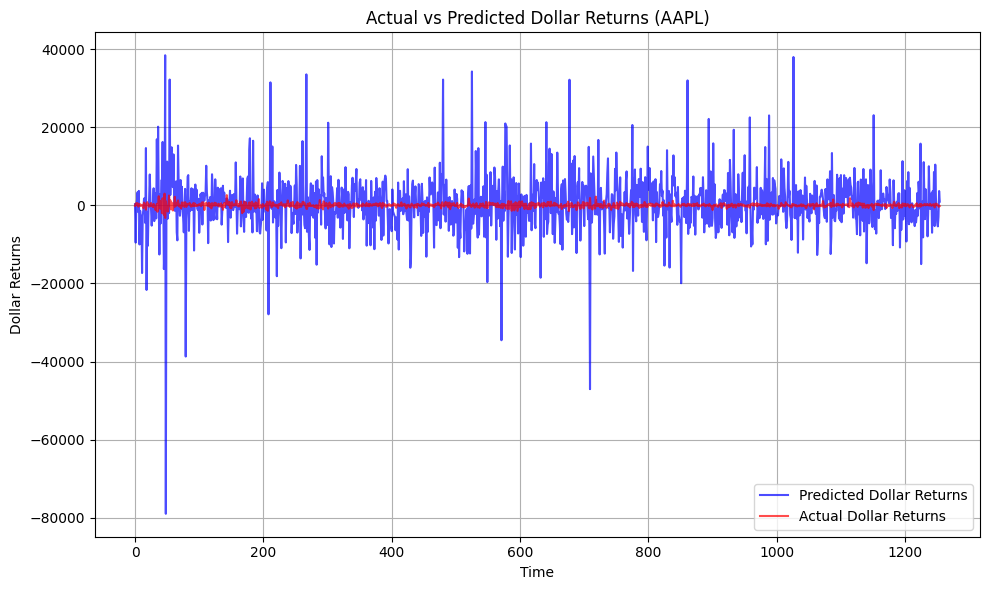

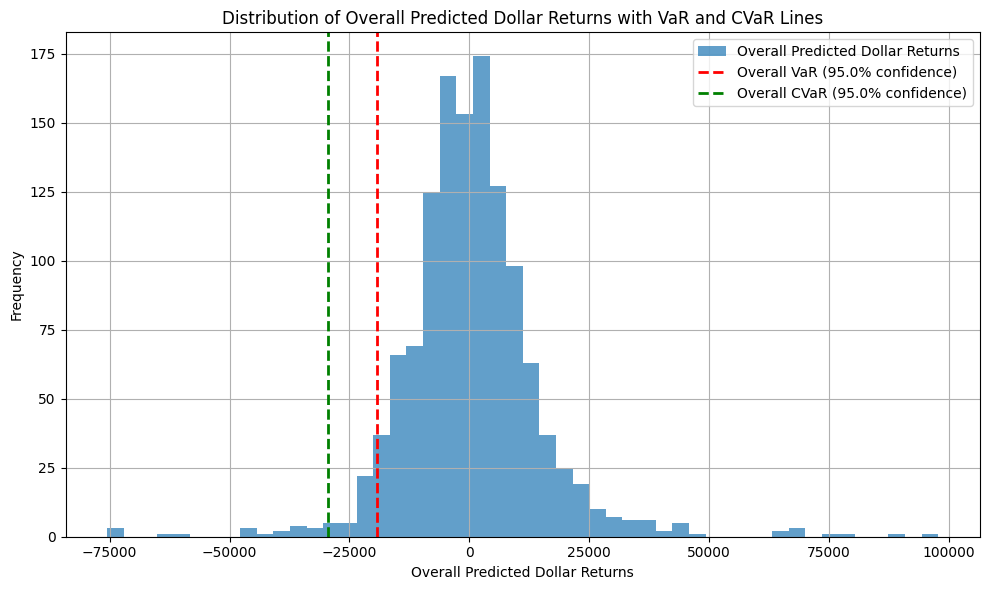

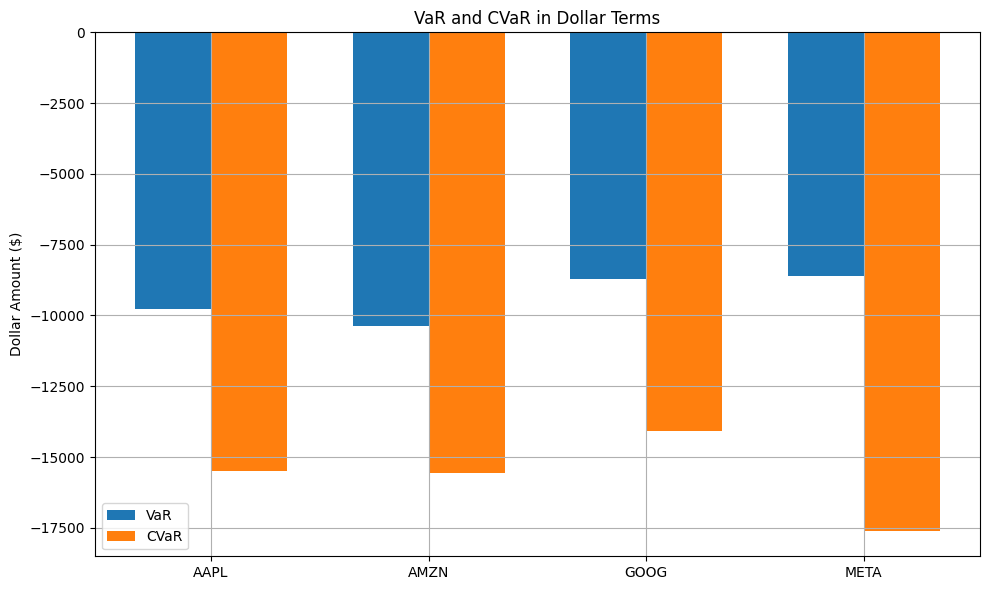

In [ ]:
confidence_level = 0.95

var_predictions_dollar = {}
cvar_predictions_dollar = {}

for i, stock in enumerate(df.columns):
    sorted_predicted = np.sort(predicted_dollar_returns[:, i])
    var_index = int((1 - confidence_level) * len(sorted_predicted))
    VaR_dollar = sorted_predicted[var_index]
    var_cvar_dollar = sorted_predicted[:var_index].mean()

    var_predictions_dollar[stock] = VaR_dollar
    cvar_predictions_dollar[stock] = var_cvar_dollar

# 1. Plot Actual vs Predicted Dollar Returns for the first stock
plt.figure(figsize=(10, 6))
plt.plot(
    predicted_dollar_returns_aligned[:, 0],
    label="Predicted Dollar Returns",
    alpha=0.7,
    color="b",
)
plt.plot(
    y_tensor.numpy()[1:, 0] * investment_per_stock,
    label="Actual Dollar Returns",
    alpha=0.7,
    color="r",
)
plt.title("Actual vs Predicted Dollar Returns (AAPL)")
plt.xlabel("Time")
plt.ylabel("Dollar Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("nn-plots/actual_vs_predicted_dollar_returns.png")
plt.show()

# 2. Plot Distribution of Overall Predicted Dollar Returns with VaR and CVaR Lines
overall_predicted_dollar_returns = predicted_dollar_returns.sum(axis=1)
sorted_overall_predicted = np.sort(overall_predicted_dollar_returns)
var_index = int((1 - confidence_level) * len(sorted_overall_predicted))
VaR_overall = sorted_overall_predicted[var_index]
CVaR_overall = sorted_overall_predicted[:var_index].mean()

plt.figure(figsize=(10, 6))
plt.hist(
    overall_predicted_dollar_returns,
    bins=50,
    alpha=0.7,
    label="Overall Predicted Dollar Returns",
)

# Plot VaR and CVaR lines (95% confidence level) for overall returns
plt.axvline(
    VaR_overall,
    color="r",
    linestyle="dashed",
    linewidth=2,
    label=f"Overall VaR ({confidence_level*100}% confidence)",
)
plt.axvline(
    CVaR_overall,
    color="g",
    linestyle="dashed",
    linewidth=2,
    label=f"Overall CVaR ({confidence_level*100}% confidence)",
)

plt.title("Distribution of Overall Predicted Dollar Returns with VaR and CVaR Lines")
plt.xlabel("Overall Predicted Dollar Returns")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("nn-plots/distribution_overall_predicted_dollar_returns.png")
plt.show()

# 3. Bar Plot for VaR and CVaR in Dollar Terms for each stock
var_values = [var_predictions_dollar[stock] for stock in df.columns]
cvar_values = [cvar_predictions_dollar[stock] for stock in df.columns]
x = np.arange(len(df.columns))
width = 0.35

plt.figure(figsize=(10, 6))
bars_var = plt.bar(x - width / 2, var_values, width, label="VaR")
bars_cvar = plt.bar(x + width / 2, cvar_values, width, label="CVaR")

plt.title("VaR and CVaR in Dollar Terms")
plt.xticks(x, df.columns)
plt.ylabel("Dollar Amount ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("nn-plots/var_cvar_dollar_terms.png")
plt.show()